# Multi $\kappa$ Scale Factor
This applies the scale factor theory to all simulations, through regression.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_temp_adiabat
from isca_tools.thesis.adiabat_theory2 import get_approx_terms, get_scale_factor_theory
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [480]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
kappa_names.sort()
n_kappa = len(kappa_names)

ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
tau_lw = np.asarray(tau_lw)
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

  0%|          | 0/8 [00:00<?, ?it/s]

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [481]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5, 'two_thirds': 4.5}        # width in inches
save_pad_inches = 0.05
im_sz = 1.5


# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_exp = plt.cm.jet(np.linspace(0, 1, n_kappa))
ax_linewidth = plt.rcParams['axes.linewidth']
lw_publish = 1

labels_exp = ['$\kappa={:.1f}$'.format(tau_lw[i]) for i in range(n_kappa)]

In [482]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [483]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_min = 70
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]
lat = ds[0].lat[lat_use_ind].to_numpy()

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
z_approx_error_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}        # error in z used in mse_mod approx
# Decide how to compute humidities - do q first and then r from this ('sphum'), or vice versa ('r')?

R_mod = get_theory_prefactor_terms(0, p_surface, pressure_ft_actual)[0]   # need to compute mse_mod

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season in ['summer', 'winter']:
            ds_nh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
            ds_sh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_season, ds_nh_season], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
        temp_av['median'][j] = ds_use.temp.median(dim='lon_time')
        z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
        z_av['median'][j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_av['mean'][j] = rh_use.mean(dim='lon_time')
        r_av['median'][j] = rh_use.median(dim='lon_time')
        mse_use_surf = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=ds_use.height.isel(pfull=ind_surf))
        mse_use_ft = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                         height=ds_use.height.isel(pfull=ind_ft))
        epsilon_use = mse_use_surf-mse_use_ft
        epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
        epsilon_av['median'][j] = epsilon_use.median(dim='lon_time')
        mse_mod_use = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=0, c_p_const=c_p-R_mod
                                          ) - epsilon_use
        mse_mod_use_ft_approx = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                                    height=0, c_p_const=c_p+R_mod)
        z_error_use = mse_mod_use - mse_mod_use_ft_approx
        z_approx_error_av['mean'][j] = z_error_use.mean(dim='lon_time')
        z_approx_error_av['median'][j] = z_error_use.median(dim='lon_time')
        pbar.update(1)

  0%|          | 0/8 [00:00<?, ?it/s]

In [484]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                pbar.update(1)

# computed as in get_scaling_factor_theory function in adiabat_theory.py, computing sphum quant first
# Really doesn't matter though but I think this method is simpler
# When computing average, I think it does make more sense to compute sphum_av from r_av because theory built around RH
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)

  0%|          | 0/11088 [00:00<?, ?it/s]

In [485]:
# Copy epsilon calculation from get_scaling_factor_theory function in adiabat_theory.py
# In units of kJ/kg
epsilon_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=z_quant3[:, ind_surf]) -
                 moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft]))
# epsilon_av = {}
# for key in ['mean', 'median']:
#     epsilon_av[key] = (moist_static_energy(temp_av[key][:, ind_surf], r_av[key] * sphum_sat(temp_av[key][:, ind_surf], p_surface), height=0) -
#                        moist_static_energy(temp_av[key][:, ind_ft], sphum_sat(temp_av[key][:, ind_ft], pressure_ft_actual), z_av[key][:, ind_ft]))

## Reference Climate
In the theory, we are free to choose the reference day, and the change with warming of this day, that the theory is built around. We must specify the reference surface temperature, $\tilde{T}_s$, relative humidity, $\tilde{r}_s$, CAPE proxy, $\tilde{\epsilon}$ and error due to approximation of geopotential height, $\tilde{A}_z$.

Given these three values, we can compute the reference free tropospheric temperature, $\tilde{T}_{FT}$, by equating two equations for reference modified MSE, $\tilde{h}^{\dagger}$:

$\tilde{h}^{\dagger} = (c_p - R^{\dagger})\tilde{T}_s + L_v \tilde{q}_s - \epsilon = (c_p + R^{\dagger})\tilde{T}_{FT} + L_vq^*(\tilde{T}_{FT}, p_{FT})
 + \tilde{A}_z$

Where we use the computed average error due to z approximation, $\tilde{A}_z$ in this computation of $\tilde{T}_{FT}$.

For ease of interpretation later, I propose:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$
* $\tilde{A}_z = \overline{A}_z; \delta \tilde{A}_z = 0$

where the overline refers to the time-zonal mean value of that quantity.

In [486]:
av_use = 'mean'
# Recommended reference day
# SUBTLE POINT FOR REF RH WHEN USING MULTIPLE SIMULATIONS
# for each neighbouring simulation, assume r_ref constant with warming hence add duplicate 3rd axis
# shape is n_exp x n_lat x 2 so to get scale factor for experiment i to i+1 latitude j, give r_ref[i, j, :]
r_ref = np.tile(r_av[av_use][:, :, np.newaxis], [1, 1, 2])
epsilon_ref = np.zeros((n_kappa, n_lat))        # Normalise relative to day with zero CAPE in each simulation         # use actual average epsilon
temp_surf_ref = temp_av[av_use][:, ind_surf] # Have actual average surface temperature change with warming
z_approx_error_ref = np.zeros((n_kappa, n_lat))

# Amendment if want to use actual average day as reference in both climates
use_av_as_ref = False
if use_av_as_ref:
    r_ref[:-1, :, 1] = r_av[av_use][1:]        # account for actual change in reference between subsequent experiments
    epsilon_ref[:] = epsilon_av[av_use]
    z_approx_error_ref[:] = z_approx_error_av[av_use]

In [487]:
# Combine data required for plotting from aquaplanet and land into 1 dictionary
# Need to run through notebook twice (one with aquaplanet data loaded, one with land data loaded) to get final dict
try:
    plot_info       # check if variable exists
except NameError:
    plot_info = {key: {'temp_s_anom': np.zeros_like(temp_quant3[:, ind_surf])} for key in ['aquaplanet', 'land']}
plot_info['land' if is_land_data else 'aquaplanet']['temp_s_anom'] = temp_quant3[:, ind_surf] - temp_av[av_use][:, ind_surf, :, np.newaxis]

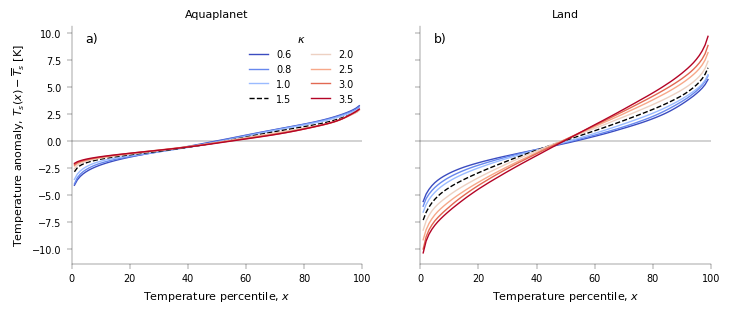

In [574]:
colors_kappa = plt.cm.coolwarm(np.linspace(0, 1, n_kappa))
colors_kappa = np.concatenate([colors_kappa[:3], np.asarray([0, 0, 0, 1])[np.newaxis], colors_kappa[4:]])

save_temp_anom_fig = True
fig, ax = plt.subplots(1,2, figsize=(im_sz*width['two_col'], im_sz*width['two_col']/ar/2), sharex=True, sharey=True)
for j, key in enumerate(plot_info):
    ax[j].set_title(key.capitalize())
    ax[j].axhline(0, color='k', lw=ax_linewidth)
    ax[j].set_xlabel('Temperature percentile, $x$')
    for i in range(n_kappa):
        ax[j].plot(quant_plot, np.average(plot_info[key]['temp_s_anom'][i], axis=0, weights=lat_weights),
               color=colors_kappa[i], label='{:.1f}'.format(tau_lw[i]), lw=lw_publish, linestyle='--' if i==3 else None)
ax[0].legend(ncol=2, title='$\kappa$', loc='upper right')
ax[0].set_ylabel('Temperature anomaly, $T_s(x)-\overline{T}_s$ [K]')
ax[0].set_xlim(0, 100)
label_subplots(fig, ax)
plt.show()
if save_temp_anom_fig:
    isca_tools.savefig(fig, 'temp_surf_anom', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

In [566]:
def get_gradient(temp_quant, temp_ref, ref_ind, confidence=0.9):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
            Temperature of given quantile for each experiment
        temp_ref: [n_exp]
            Reference temperature for each experiment
        ref_ind: int
            Regression line will go through (temp_ref[ref_ind], temp_quant[ref_ind])
            I.e. it sets the intercept
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient K/K
        [n_exp]
            Predicted temperature for each experiment
        float
            Confidence value for the gradient, such that there is the desired confidence
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x - temp_ref[ref_ind])     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func, temp_ref, temp_quant)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return param, fit_func(temp_ref, param), z_score * param_std

In [490]:
# Get variable as function of x responsible for each mechanism
delta_temp_quant_theory_var = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in
                               ['temp_ft_change', 'r_change', 'epsilon_change', 'temp_anom', 'r_anom', 'epsilon_anom']}
for i in range(n_lat):
    for j in range(n_kappa-1):
        # For anom mechanisms, just take anom and multiply by temp_s difference
        delta_temp_quant_theory_var['temp_anom'][j+1, i] = (temp_quant3[j, ind_surf, i] -
                                                            temp_surf_ref[j, i]) * np.diff(temp_surf_ref[j:j+2, i], axis=0)
        delta_temp_quant_theory_var['r_anom'][j+1, i] = (r_quant3[j, i] -
                                                         r_ref[j, i, 0]) * np.diff(temp_surf_ref[j:j+2, i], axis=0) * 100
        delta_temp_quant_theory_var['epsilon_anom'][j+1, i] = (epsilon_quant3[j, i] -
                                                         epsilon_ref[j, i]) * np.diff(temp_surf_ref[j:j+2, i], axis=0)
        # For change mechanisms, just add change of the actual variable
        delta_temp_quant_theory_var['temp_ft_change'][j+1, i] = np.diff(temp_quant3[j:j+2, ind_ft, i], axis=0)
        delta_temp_quant_theory_var['r_change'][j+1, i] = np.diff(r_quant3[j:j+2, i], axis=0) * 100
        delta_temp_quant_theory_var['epsilon_change'][j+1, i] = np.diff(epsilon_quant3[j:j+2, i], axis=0)
temp_surf_quant3_theory_var = {key: np.cumsum(delta_temp_quant_theory_var[key], axis=0) for key in delta_temp_quant_theory_var}

In [491]:
# Consider 3 different groups of simulations: all; all below kappa=1. all above kappa=1
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1.5)[0], np.where(tau_lw>=1.5)[0]]
sf_tau_ref = [1.5, 1.5, 1.5]
n_sf = len(sf_tau_use)
sf_tau_ref_ind = [int(np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]) for i in range(n_sf)]
sf_labels = [f'${tau_lw[sf_tau_use[0]].min()} \leq \kappa \leq {tau_lw[sf_tau_use[0]].max()}$',
             f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$',
             f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
confidence = 0.9        # confidence bound for error bar

In [492]:
scaling_factor_theory_var = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_var}
with tqdm(total=n_sf*n_lat*n_quant, position=0, leave=True) as pbar:
    for i in range(n_sf):
        for j in range(n_quant):
            for k in range(n_lat):
                for key in scaling_factor_theory_var:
                    scaling_factor_theory_var[key][i, k, j] = get_gradient(temp_surf_quant3_theory_var[key][sf_tau_use[i], k, j],
                                                                          temp_surf_ref[sf_tau_use[i], k],
                                                                          sf_tau_ref_ind[i], confidence)[0]
                pbar.update(1)

  0%|          | 0/4158 [00:00<?, ?it/s]

In [493]:
# Combine data required for plotting from aquaplanet and land into 1 dictionary
# Need to run through notebook twice (one with aquaplanet data loaded, one with land data loaded) to get final dict
for key in ['aquaplanet', 'land']:
    try:
        plot_info[key]['sf_theory_var']       # just to check if key exists
    except KeyError:
        # If variable doesn't exist, create it with all values set to 0
        plot_info[key]['sf_theory_var'] = {key2: np.zeros_like(scaling_factor_theory_var[key2]) for key2 in scaling_factor_theory_var}

for key in scaling_factor_theory_var:
    plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_var'][key][:] = scaling_factor_theory_var[key]

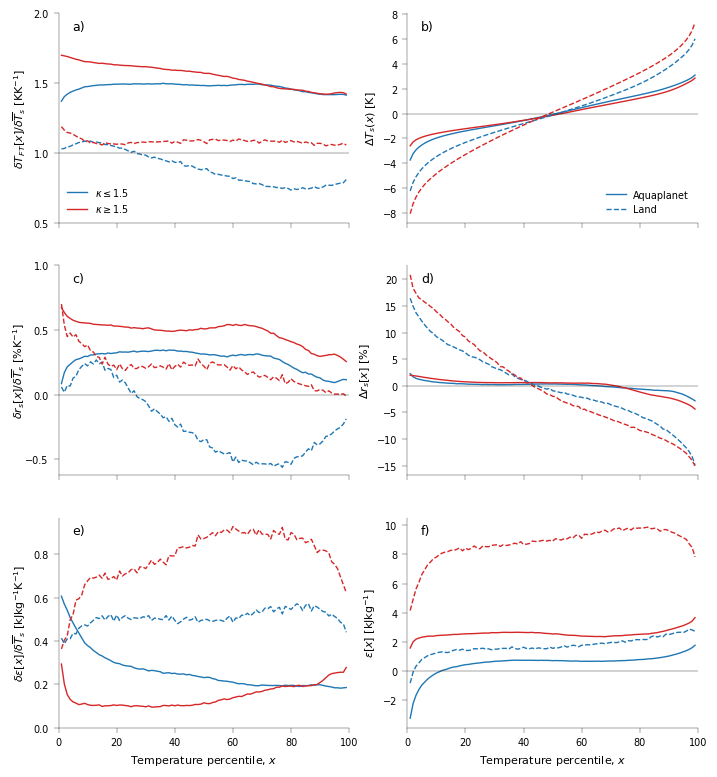

In [598]:
colors_sf_tau = ['k', default_colors[0], default_colors[3]]
linestyles_surf = {'aquaplanet': '-', 'land': '--'}
labels_var = {'temp_ft_change': '$\delta T_{FT}[x]/\delta \overline{T}_s$ [KK$^{-1}$]',
              'r_change': '$\delta r_s[x]/\delta \overline{T}_s$ [%K$^{-1}$]',
              'epsilon_change': '$\delta \epsilon[x]/\delta \overline{T}_s$ [kJkg$^{-1}$K$^{-1}$]',
              'temp_anom': '$\Delta T_s(x)$ [K]', 'r_anom': '$\Delta r_s[x]$ [%]', 'epsilon_anom': '$\epsilon[x]$ [kJkg$^{-1}$]'}

save_sf_theory_var_fig = False
fig, ax = plt.subplots(3,2, figsize=(im_sz*width['two_col'], im_sz*3*width['two_col']/2/ar), sharex=True)
label_subplots(fig, ax.flatten(), box_alpha=0)
ax = ax.transpose().flatten()
for k, key in enumerate(scaling_factor_theory_var):
    for j, key2 in enumerate(plot_info):
        for i in range(1, 3):
            if k == 0:
                label_use = sf_labels[i] if j==0 else None
            else:
                label_use = key2.capitalize() if i==1 else None
            ax[k].plot(quant_plot, np.average(plot_info[key2]['sf_theory_var'][key][i], axis=0, weights=lat_weights), lw=lw_publish,
                       color=colors_sf_tau[i], linestyle=linestyles_surf[key2], label=label_use)
    ax[k].set_ylabel(labels_var[key])
    if key not in ['temp_ft_change', 'epsilon_change']:
        ax[k].axhline(0, color='k', lw=ax_linewidth)
ax[0].axhline(1, color='k', lw=ax_linewidth)
ax[2].set_ylim(0, ax[2].get_ylim()[1])
ax[0].set_ylim(0.5, 2)
ax[0].set_yticks(np.arange(0.5, 2.5, 0.5))      # change tick frequency
ax[1].set_yticks(np.arange(-0.5, 1.5, 0.5))
ax[1].yaxis.set_label_coords(-0.11, 0.5)        # manually move y label as negative value causes it to be too far away
ax[1].set_ylim(ax[1].get_ylim()[0], 1)
ax[0].legend(loc='lower left')
ax[3].legend(loc='lower right')
ax[2].set_xlabel('Temperature percentile, $x$')
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_xlim(0, 100)
# plt.subplots_adjust(wspace=0.25)
plt.show()
if save_sf_theory_var_fig:
    isca_tools.savefig(fig, 'sf_theory_var', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

In [496]:
# delta_temp_quant_theory[0] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant_theory = {method: np.zeros((n_kappa, n_lat, n_quant)) for method in
                           ['linear', 'non-linear']}
delta_temp_quant_theory_cont = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in ['temp_ft_change', 'r_change', 'epsilon_change',
                                                                            'temp_anom', 'r_anom', 'epsilon_anom']}
delta_temp_quant_theory_approx = {key: np.zeros((n_kappa, n_lat, n_quant)) for key in
                                  ['temp_ft_anom_change', 'temp_s_anom_change', 'r_change', 'temp_s_anom_r_change', 'anom_temp_s_r',
                                   'anom', 'ref_change', 'z_anom_change', 'nl']}
for method in delta_temp_quant_theory:
    for i in range(n_lat):
        for j in range(n_kappa-1):
            delta_temp_quant_theory[method][j+1, i], _, _, var = \
                    get_scale_factor_theory(temp_surf_ref[j:j+2, i], temp_quant3[j:j+2, ind_surf, i], r_ref[j, i], r_quant3[j:j+2, i],
                                                                   temp_quant3[j:j+2, ind_ft, i], epsilon_quant3[j:j+2, i], p_surface,
                                                                   pressure_ft_actual, epsilon_ref[j:j+2, i], z_approx_error_ref[j:j+2, i], include_non_linear=True if method=='non-linear' else False)
            delta_temp_quant_theory[method][j+1, i] *= np.diff(temp_surf_ref[j:j+2, i], axis=0)
            for key in delta_temp_quant_theory_cont:
                delta_temp_quant_theory_cont[key][j+1, i] = var[key] * np.diff(temp_surf_ref[j:j+2, i], axis=0)
            # Get approx info
            var = get_approx_terms(temp_surf_ref[j:j+2, i], temp_quant3[j:j+2, ind_surf, i], r_ref[j, i], r_quant3[j:j+2, i],
                                   temp_quant3[j:j+2, ind_ft, i], epsilon_quant3[j:j+2, i], p_surface, pressure_ft_actual,
                                   epsilon_ref[j:j+2, i], z_approx_error_ref[j:j+2, i])[0]
            for key in delta_temp_quant_theory_approx:
                delta_temp_quant_theory_approx[key][j+1, i] = var[key] * np.diff(temp_surf_ref[j:j+2, i], axis=0)
temp_surf_quant3_theory = {method: temp_quant3[0, ind_surf] + np.cumsum(delta_temp_quant_theory[method], axis=0) for method in delta_temp_quant_theory}
temp_surf_quant3_theory_cont = {key: np.cumsum(delta_temp_quant_theory_cont[key], axis=0) for key in delta_temp_quant_theory_cont}
temp_surf_quant3_theory_approx = {key: np.cumsum(delta_temp_quant_theory_approx[key], axis=0) for key in delta_temp_quant_theory_approx}

In [497]:
# Sanity check that theory is working
show_plot = False
plot_lat_ind = -5
plot_quant_ind = -93

fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
ax.plot(temp_surf_ref[:, plot_lat_ind], temp_quant3[:, ind_surf, plot_lat_ind, plot_quant_ind], color='k', marker='o', label='Simulated')
ax.plot(temp_surf_ref[:, plot_lat_ind], temp_surf_quant3_theory['linear'][:, plot_lat_ind, plot_quant_ind], color='k', linestyle=':', label='Theory')
ax.set_xlabel('$\overline{T}_s$ [K]')
ax.set_ylabel(f'$T_s(x={quant_plot[plot_quant_ind]})$ [K]')
ax.legend()
ax.set_title('Lat={:.2f}$\degree$'.format(ds_all[0].lat[plot_lat_ind]))
if show_plot:
    plt.show()
else:
    plt.close()

In [498]:
# Consider 3 different groups of simulations: all; all below kappa=1. all above kappa=1
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1.5)[0], np.where(tau_lw>=1.5)[0]]
sf_tau_ref = [1.5, 1.5, 1.5]
n_sf = len(sf_tau_use)
sf_tau_ref_ind = [int(np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]) for i in range(n_sf)]
sf_labels = [f'${tau_lw[sf_tau_use[0]].min()} \leq \kappa \leq {tau_lw[sf_tau_use[0]].max()}$',
             f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$',
             f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
confidence = 0.9        # confidence bound for error bar

scaling_factor = np.zeros((n_sf, n_lat, n_quant))
scaling_factor_error = np.zeros((n_sf, n_lat, n_quant))
scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant)) for method in delta_temp_quant_theory}
scaling_factor_theory_cont = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_cont}
scaling_factor_theory_approx = {key: np.zeros((n_sf, n_lat, n_quant)) for key in delta_temp_quant_theory_approx}

with tqdm(total=n_sf*n_lat*n_quant, position=0, leave=True) as pbar:
    for i in range(n_sf):
        for j in range(n_quant):
            # The theory predicts median change but not mean hence I use median rather than mean.
            # This means can get theoretical scale factor rather than using simulated mean.
            # This means x=50 will correspond to y=1 in all plots below.
            # Straight line through the ref point
            for k in range(n_lat):
                scaling_factor[i, k, j], _, scaling_factor_error[i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j],
                                                                                         temp_surf_ref[sf_tau_use[i], k], sf_tau_ref_ind[i],
                                                                                         confidence)
                for method in scaling_factor_theory:
                    scaling_factor_theory[method][i, k, j] = get_gradient(temp_surf_quant3_theory[method][sf_tau_use[i], k, j],
                                                                          temp_surf_ref[sf_tau_use[i], k],
                                                                          sf_tau_ref_ind[i], confidence)[0]
                for key in scaling_factor_theory_cont:
                    scaling_factor_theory_cont[key][i, k, j] = get_gradient(temp_surf_quant3_theory_cont[key][sf_tau_use[i], k, j],
                                                                          temp_surf_ref[sf_tau_use[i], k],
                                                                          sf_tau_ref_ind[i], confidence)[0]
                for key in scaling_factor_theory_approx:
                    scaling_factor_theory_approx[key][i, k, j] = get_gradient(temp_surf_quant3_theory_approx[key][sf_tau_use[i], k, j],
                                                                          temp_surf_ref[sf_tau_use[i], k],
                                                                          sf_tau_ref_ind[i], confidence)[0]
                pbar.update(1)

  0%|          | 0/4158 [00:00<?, ?it/s]

In [499]:
# Combine data required for plotting from aquaplanet and land into 1 dictionary
# Need to run through notebook twice (one with aquaplanet data loaded, one with land data loaded) to get final dict

# arrays below are just all zero with correct size to initialise plot_info entries
zero_plot_info_arrays = {'sf': np.zeros_like(scaling_factor),'sf_error': np.zeros_like(scaling_factor_error),
                         'sf_theory': {key2: np.zeros_like(scaling_factor_theory[key2]) for key2 in scaling_factor_theory},
                         'sf_theory_cont': {key2: np.zeros_like(scaling_factor_theory_cont[key2]) for key2 in scaling_factor_theory_cont},
                         'sf_theory_approx': {key2: np.zeros_like(scaling_factor_theory_approx[key2]) for key2 in scaling_factor_theory_approx}}
for key in ['aquaplanet', 'land']:
    for key2 in ['sf', 'sf_error', 'sf_theory', 'sf_theory_cont', 'sf_theory_approx']:
        try:
            plot_info[key][key2]       # just to key exists
        except KeyError:
            # If variable doesn't exist, create it with all values set to 0
            plot_info[key][key2] = zero_plot_info_arrays[key2]

# Update plot dict for current loaded simulation
plot_info['land' if is_land_data else 'aquaplanet']['sf'][:] = scaling_factor
plot_info['land' if is_land_data else 'aquaplanet']['sf_error'][:] = scaling_factor_error
plot_info['land' if is_land_data else 'aquaplanet']['sf_theory']['linear'][:] = scaling_factor_theory['linear']
plot_info['land' if is_land_data else 'aquaplanet']['sf_theory']['non-linear'][:] = scaling_factor_theory['non-linear']
for key in scaling_factor_theory_cont:
    plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_cont'][key][:] = scaling_factor_theory_cont[key]
for key in scaling_factor_theory_approx:
    plot_info['land' if is_land_data else 'aquaplanet']['sf_theory_approx'][key][:] = scaling_factor_theory_approx[key]

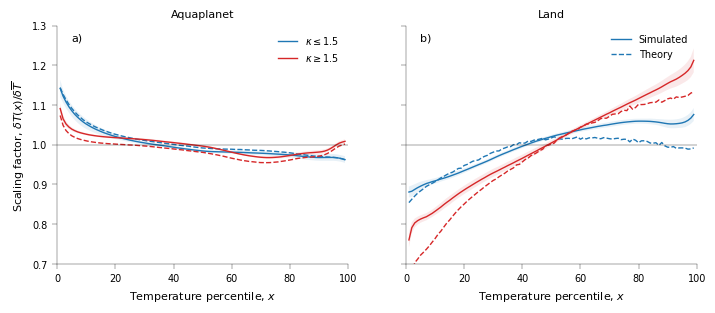

In [599]:
save_sf_theory_fig = False
fig, ax = plt.subplots(1,2, figsize=(im_sz*width['two_col'], im_sz*width['two_col']/2/ar), sharex=True, sharey=True)
for j, key in enumerate(plot_info):
    for i in range(1, 3):
        if key=='land':
            label_use = 'Simulated' if i==1 else None
        else:
            label_use = sf_labels[i]
        ax[j].plot(quant_plot, np.average(plot_info[key]['sf'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                   label=label_use, lw=lw_publish)
        ax[j].plot(quant_plot, np.average(plot_info[key]['sf_theory']['linear'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
                   linestyle='--', lw=lw_publish, label='Theory' if (key=='land' and i==1) else None)
        # ax.plot(quant_plot, np.average(scaling_factor_theory['non-linear'][i], axis=0, weights=lat_weights), color=default_colors[0+3*(i-1)],
        #     linestyle=':', lw=lw_publish, label='Theory (non-linear)' if (is_land_data and i==1) else None)
        ax[j].fill_between(quant_plot, np.average(plot_info[key]['sf'][i]-plot_info[key]['sf_error'][i], axis=0, weights=lat_weights),
                        np.average(plot_info[key]['sf'][i]+plot_info[key]['sf_error'][i], axis=0, weights=lat_weights),
                        fc=default_colors[0+3*(i-1)], alpha=0.1)

    ax[j].axhline(1, linewidth=ax_linewidth, color='k')
    ax[j].set_xlabel('Temperature percentile, $x$')
    ax[j].legend(loc='upper right')
    ax[j].set_title(key.capitalize())
ax[0].set_xlim(0,100)
ax[0].set_ylim(0.7,1.3)
label_subplots(fig, ax, fontsize=8)
ax[0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
plt.show()
if save_sf_theory_fig:
    isca_tools.savefig(fig, 'sf_theory', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

In [501]:
plot_sf_ind_use = 0
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
ax.plot(quant_plot, np.average(scaling_factor[plot_sf_ind_use], axis=0, weights=lat_weights), color='b', label='Simulated')
ax.plot(quant_plot, np.average(scaling_factor_theory['linear'][plot_sf_ind_use], axis=0, weights=lat_weights), color='k',
        linestyle='--', label=f'Theory')
# Add error
ax.fill_between(quant_plot, np.average(scaling_factor[plot_sf_ind_use]-scaling_factor_error[plot_sf_ind_use], axis=0, weights=lat_weights),
                np.average(scaling_factor[plot_sf_ind_use]+scaling_factor_error[plot_sf_ind_use], axis=0, weights=lat_weights), fc='b', alpha=0.1)
ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend()
ax.set_xlim(0,100)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if show_plot:
    plt.show()
else:
    plt.close()

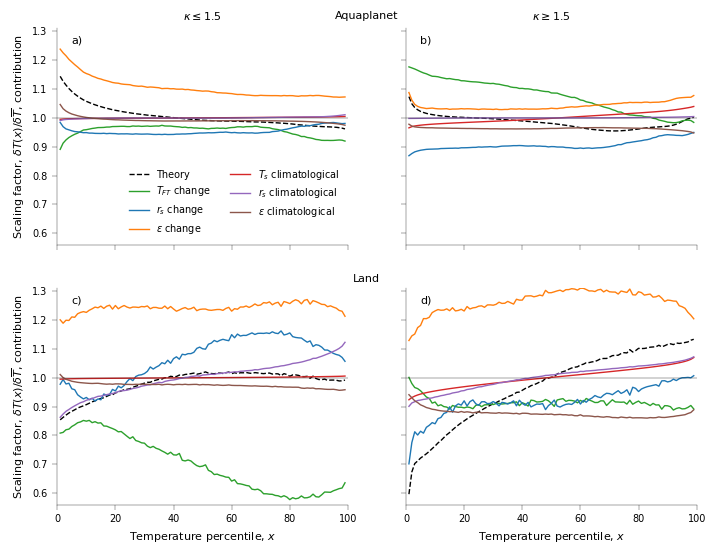

In [580]:
colors_cont = {'temp_ft_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[4],
               'r_change': default_colors[0],
               'epsilon_anom': default_colors[5],
               'epsilon_change': default_colors[1]}
labels_cont = {'temp_ft_change': '$T_{FT}$ change', 'r_change': '$r_s$ change', 'epsilon_change': '$\epsilon$ change',
               'temp_anom': '$T_s$ climatological', 'r_anom': '$r_s$ climatological', 'epsilon_anom': '$\epsilon$ climatological'}

save_sf_breakdown_fig = False
fig, ax = plt.subplots(2,2, figsize=(im_sz*width['two_col'], 2*im_sz*width['two_col']/2/ar), sharey=True, sharex=True)
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        ax[j, i-1].plot(quant_plot, np.average(plot_info[key2]['sf_theory']['linear'][i], axis=0, weights=lat_weights),
                        color='k', lw=1, linestyle='--', label='Theory')
        for key in scaling_factor_theory_cont:
            ax[j, i-1].plot(quant_plot, (0 if 'ft' in key else 1)+np.average(plot_info[key2]['sf_theory_cont'][key][i], axis=0, weights=lat_weights),
                    color=colors_cont[key], lw=lw_publish, label=labels_cont[key])
        ax[j, i-1].axhline(1, color='k', lw=ax_linewidth)
    ax[j, 0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$, contribution')

ax[0, 0].set_title(sf_labels[1])
ax[0, 1].set_title(sf_labels[2])
ax[0, 0].legend(ncol=2, loc='lower right')
label_subplots(fig, ax.flatten(), fontsize=8)
ax[0, 0].set_xlim(0,100)
ax[0, 0].set_ylim(0.56, 1.31)
ax[1, 0].set_xlabel('Temperature percentile, $x$')
ax[1, 1].set_xlabel('Temperature percentile, $x$')
fig.text(0.5, 0.895, "Aquaplanet", ha='center', fontsize=8)
fig.text(0.5, 0.47, "Land", ha='center', fontsize=8)
plt.show()
if save_sf_breakdown_fig:
    isca_tools.savefig(fig, 'sf_breakdown', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

In [503]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar))
for key in scaling_factor_theory_cont:
    ax.plot(quant_plot, np.average(scaling_factor_theory_cont[key][2]-scaling_factor_theory_cont[key][1], axis=0, weights=lat_weights),
               label=key, color=colors_cont[key])
ax.set_xlim(0,100)
ax.hlines(0, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend(ncol=2)
ax.set_xlabel('Temperature percentile, $x$')
if show_plot:
    plt.show()
else:
    plt.close()

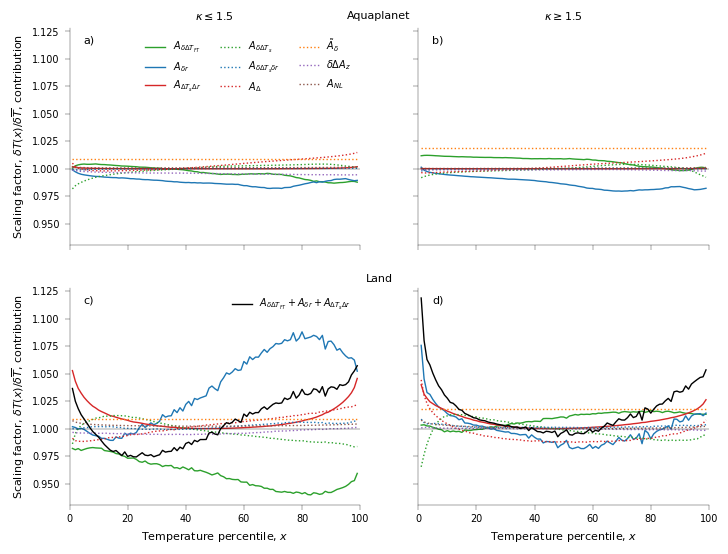

In [589]:
colors_approx = {'temp_ft_anom_change': default_colors[2], 'r_change': default_colors[0], 'anom_temp_s_r': default_colors[3],
                 'temp_s_anom_change': default_colors[2], 'temp_s_anom_r_change': default_colors[0], 'anom': default_colors[3],
                 'ref_change': default_colors[1], 'z_anom_change': default_colors[4], 'nl': default_colors[5]}
linestyles_approx = {'temp_ft_anom_change': None, 'r_change': None, 'anom_temp_s_r': None, 'ref_change': ':',
                     'temp_s_anom_change': ':', 'temp_s_anom_r_change': ':', 'z_anom_change': ':', 'anom': ':', 'nl': ':'}
labels_approx = {'temp_ft_anom_change': '$A_{\delta \Delta T_{FT}}$', 'r_change': '$A_{\delta r}$', 'anom_temp_s_r': '$A_{\Delta T_s \Delta r}$',
                 'ref_change': '$\\tilde{A}_{\delta}$', 'temp_s_anom_change': '$A_{\delta \Delta T_s}$',
                 'temp_s_anom_r_change': '$A_{\delta \Delta T_s \delta r}$', 'z_anom_change': '$\delta \Delta A_z$',
                 'anom': '$A_{\Delta}$', 'nl': '$A_{NL}$'}
label_use = ['$A_{\delta \Delta T_{FT}}+A_{\delta r}+A_{\Delta T_s \Delta r}$',
             '$A_{\delta \Delta T_s}+A_{\delta \Delta T_s \delta r}+A_{\Delta}+\\tilde{A}_{\delta}+\delta \Delta A_z+A_{NL}$']

save_sf_approx_fig = False
fig, ax = plt.subplots(2,2, figsize=(im_sz*width['two_col'], 2*im_sz*width['two_col']/2/ar), sharey=True, sharex=True)
for j, key2 in enumerate(plot_info):
    for i in range(1, 3):
        for key in colors_approx:
            ax[j, i-1].plot(quant_plot, 1+np.average(plot_info[key2]['sf_theory_approx'][key][i], axis=0, weights=lat_weights),
                    color=colors_approx[key], lw=lw_publish, label=labels_approx[key] if (i==1 and j==0) else None, linestyle=linestyles_approx[key])
        ax[j, i-1].axhline(1, color='k', lw=ax_linewidth)
        if key2 == 'land':
            ax[j, i-1].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][i]
                                                          for key in linestyles_approx if linestyles_approx[key]==None]),
                                                     axis=0, weights=lat_weights), color='k', lw=lw_publish, label=label_use[0] if i==1 else None)
            # ax[j, i-1].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][i]
            #                                               for key in linestyles_approx if linestyles_approx[key]!=None]),
            #                                          axis=0, weights=lat_weights), color='k', lw=lw_publish, linestyle=':', label=label_use[1] if i==1 else None)
    ax[j, 0].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$, contribution')

ax[0, 0].set_title(sf_labels[1])
ax[0, 1].set_title(sf_labels[2])
ax[0, 0].legend(ncol=3, loc='upper right')
ax[1, 0].legend(loc='upper right')
label_subplots(fig, ax.flatten(), fontsize=8)
ax[0, 0].set_xlim(0,100)
# ax[0, 0].set_ylim(0.56, 1.31)
ax[1, 0].set_xlabel('Temperature percentile, $x$')
ax[1, 1].set_xlabel('Temperature percentile, $x$')
fig.text(0.5, 0.895, "Aquaplanet", ha='center', fontsize=8)
fig.text(0.5, 0.47, "Land", ha='center', fontsize=8)
plt.show()
if save_sf_approx_fig:
    isca_tools.savefig(fig, 'sf_approx', dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches,
                       save_if_exists=False)

# fig, ax = plt.subplots(1,2, figsize=(2*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
# for j, key2 in enumerate(plot_info):
#     for key in colors_approx:
#         ax[j].plot(quant_plot, 1+np.average(plot_info[key2]['sf_theory_approx'][key][2], axis=0, weights=lat_weights),
#                 color=colors_approx[key], lw=lw_publish, label=labels_approx[key], linestyle=linestyles_approx[key])
#     ax[j].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][2] for key in linestyles_approx if linestyles_approx[key]==None]),
#                                         axis=0, weights=lat_weights),
#                 color='k', lw=lw_publish)
#     ax[j].plot(quant_plot, 1+np.average(sum([plot_info[key2]['sf_theory_approx'][key][2] for key in linestyles_approx if linestyles_approx[key]!=None]),
#                                         axis=0, weights=lat_weights),
#                 color='k', lw=lw_publish, linestyle='--')
#     ax[j].axhline(1, color='k', lw=ax_linewidth)
#     ax[j].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$, contribution')
# # ax[0].set_ylim(0.7, 1.3)
# ax[0].legend(ncol=3)